# Data Exploration

## Imports

In [1]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
from operator import add
import cPickle as pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

## Indexing the files

In [3]:
directory = "data/train/"
filenames = []
# Note that filenames is 0-indexed, but that there is no 0.png
# so, x.png = filenames[x-1]
for i in range(1, 33403):
    filenames.append(str(i)+'.png')

## Displaying a Sample

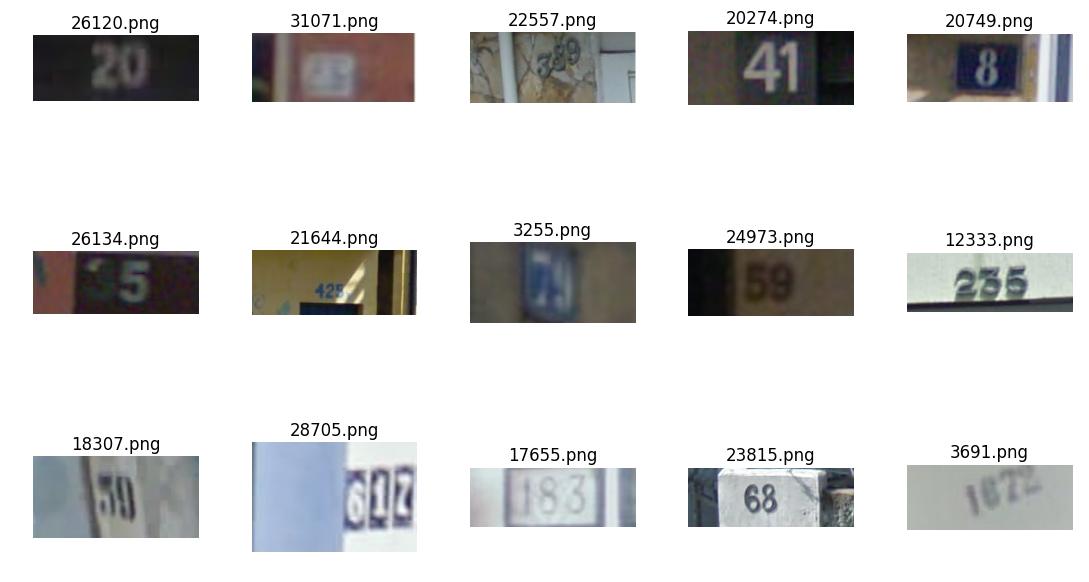

In [4]:
fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 5
for c in np.random.choice(len(filenames), rows * columns):
    img = mpimg.imread(directory + filenames[c])
    fig.add_subplot(rows, columns, i)
    i += 1
    plt.title(filenames[c])
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

## Accessing the Data
The `digitStruct.mat` file included with the SVHN dataset contains the labels of the digits in the dataset images, as well as bounding boxes that describe where in the image these digits occur.

This `.mat` file is an HDF5 file format, which unfortunately I find to be too sparsely documented for me to work with (I will spare you the code boxes in which I floundered around with `<HDF5 object reference>` and other objects I didn't know how to manipulate).

Accordingly, adopting the processing pipeline from [master_yoda](https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/3) as described in the Udacity forums, we transfer the data contained within `digitStruct.mat` into a Python dictionary for easier, more-frequently-documented manipulation.

After this (sort of lengthy) transcription has taken place, we pickle the data in accordance with master_yoda's previously-defined processing pipeline, so that on subsequent loadings of the `jupyter` notebook, we can just load the pickle file.

In [4]:
f = h5py.File(directory + 'digitStruct.mat', 'r')

In [5]:
metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

In [7]:
def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(obj[0][0])
    else:
        for k in range(obj.shape[0]):
            vals.append(f[obj[k][0]][0][0])
    metadata[name].append(vals)

In [8]:
for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(print_attrs)

### Saving the Pickle File

In [15]:
pickle_file = directory + 'train_metadata.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

### Loading the Pickle File

In [4]:
pickle_file = directory + 'train_metadata.pickle'
f = open(pickle_file, 'r')
metadata = pickle.load(f)

In [5]:
l = len(metadata['label'])

In [6]:
metadata['label'][rand.randint(0, l - 1)]

[3.0]

## Statistics

### Label Distribution

In [101]:
labels = []
for label_group in metadata['label']:
    for label in label_group:
        labels.append(label)

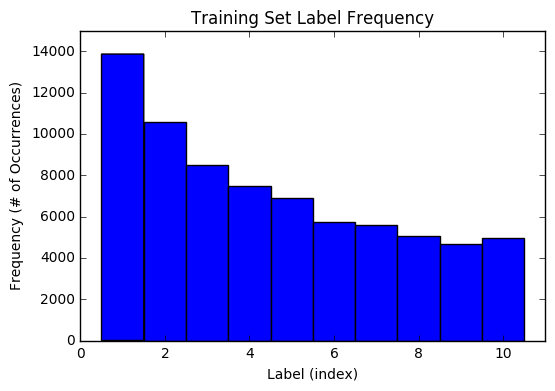

In [119]:
n, bins, patches = plt.hist(labels, bins=range(1,12), align='left')
plt.axis([0,11,0,15000])
plt.title("Training Set Label Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Label (index)")

Recall that the labels the SVHN dataset presents us with are numbers in the inclusive range (1, 10), where the labels 1 through 9 represent the digits 1 through 9, and the label 10 represents the digit 0.

So, what we see is fascinating: The digits are not uniformly distributed.  
We would expect a uniform distribution on rolls of a single die, or on the rank of cards drawn from a deck with replacement.  That is to say, we would expect uniformity if it were equally likely that any enumerated outcome could occur.

What we notice here, however, is that `1` is much more likely to occur in this dataset than is `0`, and that `0` is marginally more likely to occur in this dataset than is `9`, which is the least likely of all.  
Let's try to give more quantitative heft to this via **norming** our histogram:

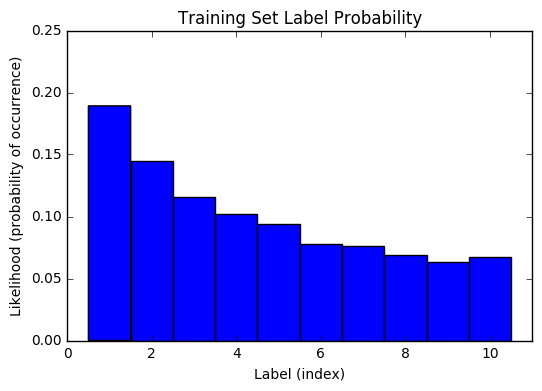

In [122]:
n, bins, patches = plt.hist(labels, bins=range(1,12), normed=True, align='left')
plt.axis([0,11,0,0.25])
plt.title("Training Set Label Probability")
plt.ylabel("Likelihood (probability of occurrence)")
plt.xlabel("Label (index)")

Revisiting our narrative from above, if we were to pick a digit at random from our dataset, there's ~20% chance that digit is a `1`, and a ~7.5% chance that digit is a `9`.

This is important to note, since if we see our model is correctly classify classifying 20% of the data, it could be the case that our model is guessing `1` for every classification.

### Image Cardinality
Just how many digits are we dealing with here anyway?!?!  
That is, what is the distribution of the number of digits per image in the SVHN dataset.

In [9]:
label_count = []
for label_group in metadata['label']:
    label_count.append(len(label_group))

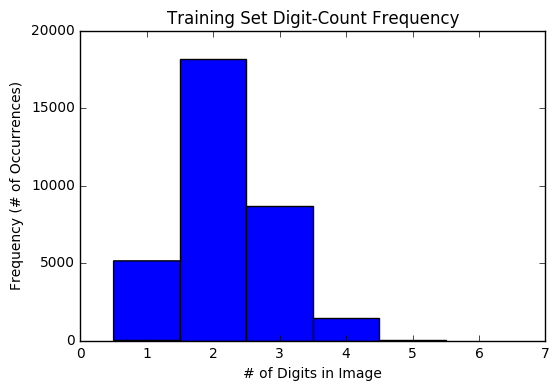

In [126]:
n, bins, patches = plt.hist(label_count, bins = range(1,7), align='left')
plt.axis([0,7,0,20000])
plt.title("Training Set Digit-Count Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("# of Digits in Image")

In [95]:
label_count.count(0), label_count.count(5), label_count.count(6)

(0, 9, 1)

Note that, in the above histogram, there are no images with `0` digits in them, and there is only one image with `6` digits in it.

It is thus perhaps the case that a Tensor which has been built to identify digits in a given image may be pre-disposed to look for two digits, regardless of whether there are 1 or 6 actually in the image.

# Exploratory Visualization

House numbers aren't always straight.  This is (1) because such precision is hard, and (2) because sometimes sloping numbers look better.

Let's explore how the numbers slope in the SVHN dataset

In [104]:
# Our bin from which to plot a degree histogram
avg_degrees = []

# Consider each image
for i in range(len(metadata['left'])):
    
    # Images with only 1 number don't have a defined number slope
    if len(metadata['left'][i]) == 1:
        continue
        
    # Our bin from which to average the angle of the numbers
    # This assumes that people _tried_ to put their house numbers on straight
    degreeses = []
    
    # for each coordinate index except the last:
    for j in range(len(metadata['left'][i]) - 1):
        
        # Handle zero-division
        if metadata['left'][i][j]-metadata['left'][i][j+1] == 0:
            # It's assumed that all vertical house numbers descend
            degreeses.append(-90)
        else:
            # Convert slope to degrees, keeping in mind that slope calculation degrades Quadrant information
            tmpDegrees = math.atan((metadata['top'][i][j+1]-metadata['top'][i][j])/(metadata['left'][i][j+1]-metadata['left'][i][j]))*180/math.pi
            
            # Add Quadrant information back in
            # i.e. whether a positive line points to Q1 or to Q3, or
            # whether a negative line points to Q4 or Q2
            diff = metadata['top'][i][j+1] - metadata['top'][i][j]
            
            # A line is positive because it points to Q3
            if diff < 0 and tmpDegrees > 0:
                tmpDegrees -= 180
            
            # A line is negative because it points to Q2
            if diff > 0 and tmpDegrees < 0:
                tmpDegrees += 180
            
            degreeses.append(tmpDegrees)
    
    # Store the average slope for the digits in this image
    avg_degrees.append(np.mean(degreeses))

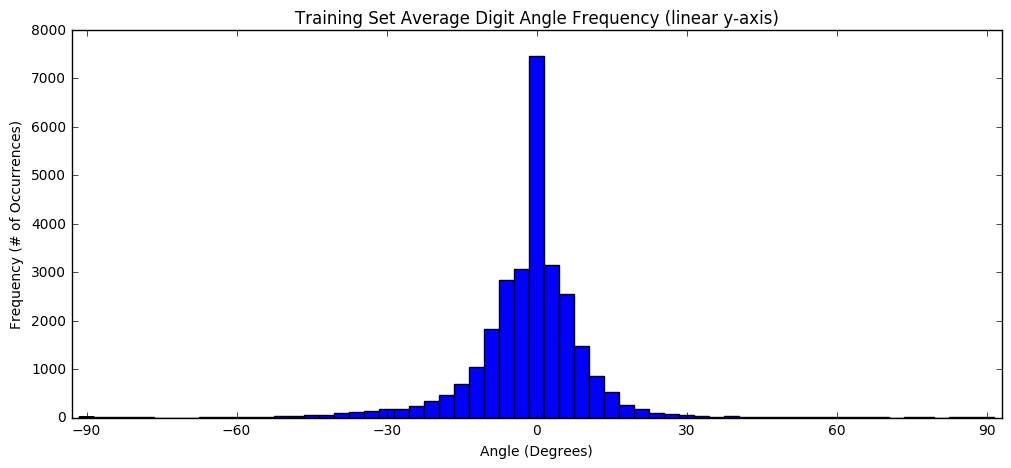

In [138]:
plt.figure(figsize=(12,5))
n, bins, patches = plt.hist(avg_degrees, bins=np.arange(-91.5,93,3), align='mid')
plt.axis([-93,93,0,8000])
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.title("Training Set Average Digit Angle Frequency (linear y-axis)")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Angle (Degrees)")

In [142]:
def gt_degrees(d):
    gt = 0
    for i in avg_degrees:
        if i > d:
            gt += 1
    return gt

def lt_degrees(d):
    lt = 0
    for i in avg_degrees:
        if i < d:
            lt += 1
    return lt

def bt_degrees(l, h):
    bt = 0
    for i in avg_degrees:
        if l < i < h:
            bt += 1
    return bt

In [144]:
gt_degrees(30), gt_degrees(60), gt_degrees(75), gt_degrees(90)

(165, 16, 9, 2)

In [145]:
bt_degrees(90, 93), bt_degrees(173,175)

(1, 1)

In [146]:
lt_degrees(-30), lt_degrees(-60), lt_degrees(-75), lt_degrees(-90), 

(685, 33, 25, 0)

In [147]:
bt_degrees(-91.5, -88.5)

12

Interestingly, as can be seen above, there are 9 images in which the slope of the numbers suggests a bottom-to-top ordering.  This almost certainly wasn't intentional.

Is this an error in the dataset?  If so, it affects only a few of the images.

Note also that there aren't any images in which the house numbers are angled beyond -90 degrees.  This suggests that no one placed numbers close enough to bottom-to-top orientation for the error inherent in placing numbers to cause that particular placement to exceed -90 degrees.  Neat!

Let's view the same plot, but with a logarithmically-scaled y-axis, to better see the above-identified outliers.

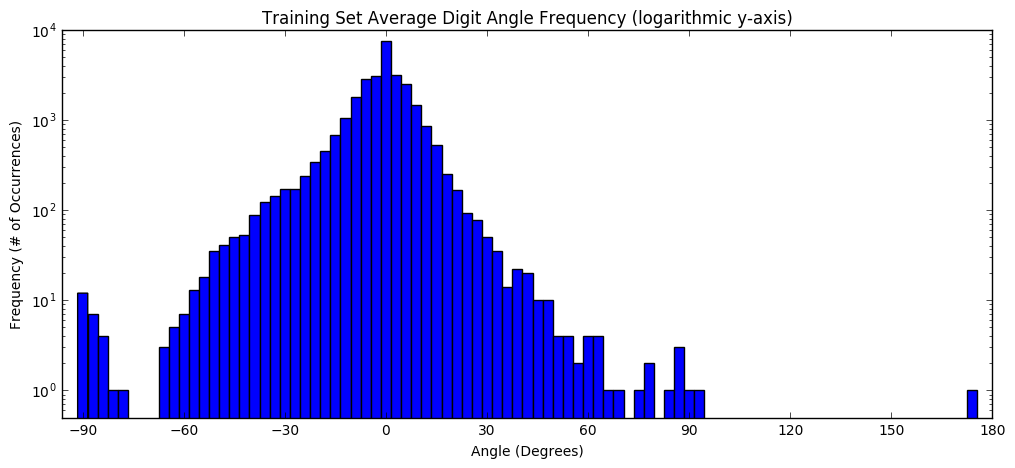

In [148]:
plt.figure(1, figsize=(12,5))
plt.yscale('log')
plt.ylim(0.5, 10000)
plt.xlim(-96, 180)
n, bins, patches = plt.hist(avg_degrees, bins=np.arange(-91.5, 180, 3), align='mid')
plt.xticks([-90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
plt.title("Training Set Average Digit Angle Frequency (logarithmic y-axis)")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Angle (Degrees)")

As we can see in the above histograms, house numbers are predominately flattish, but some slope upwards (have a positive `Angle`), and some slope downwards (have a negative `Angle`).

As expected, the tail on the negative side is fatter than on the positive side, meaning that more house numbers slope downwards than slope upwards.

This makes sense, as bottom-to-top ordering is not the reading convention anywhere.
![Writing Directions of the World](images/Writing_directions_of_the_world.svg)
(image [source](https://en.wikipedia.org/wiki/Writing_system#/media/File:Writing_directions_of_the_world.svg))  

### Relevance to Analysis
This suggests that the house numbers are, by overwhelming majority, ordered left-to-right.  Thus, after having identified digits in the SVHN images, digits can be ordered in the output based off of their `x-coordinate`, or `metadata['left']` value as referred to above.

# Algorithms and Techniques
## Image Preprocessing
The images in the SVHN dataset are many different sizes:
```
$ file *.png
...
28668.png:             PNG image data, 153 x 73, 8-bit/color RGB, non-interlaced
28669.png:             PNG image data, 67 x 34, 8-bit/color RGB, non-interlaced
2866.png:              PNG image data, 44 x 21, 8-bit/color RGB, non-interlaced
28670.png:             PNG image data, 100 x 50, 8-bit/color RGB, non-interlaced
28671.png:             PNG image data, 83 x 34, 8-bit/color RGB, non-interlaced
28672.png:             PNG image data, 108 x 49, 8-bit/color RGB, non-interlaced
...
```
Unfortunately, our neural net will need its input to be consistently-sized.  
That is to say, we need to pick *a* size to which we resize all images, before we feed them to the neural net.

Images which are larger than the destination size are going to *lose* some information, while images which are the destination size or smaller aren't going to gain information.  
Accordingly, we want to pick a size where information loss isn't significant.

A note here:  
Just because we downsize the image doesn't mean that there is significant information loss.  
A 3200x4800 image of the letter `A` is probably still faithfully represented if downsized to 32x48, or smaller.

Let's get an idea of the input dimensions:

In [10]:
img_width, img_height = [], []

for f in filenames:
    with Image.open(directory + f) as im:
        w, h = im.size
        
        img_width.append(w)
        img_height.append(h)

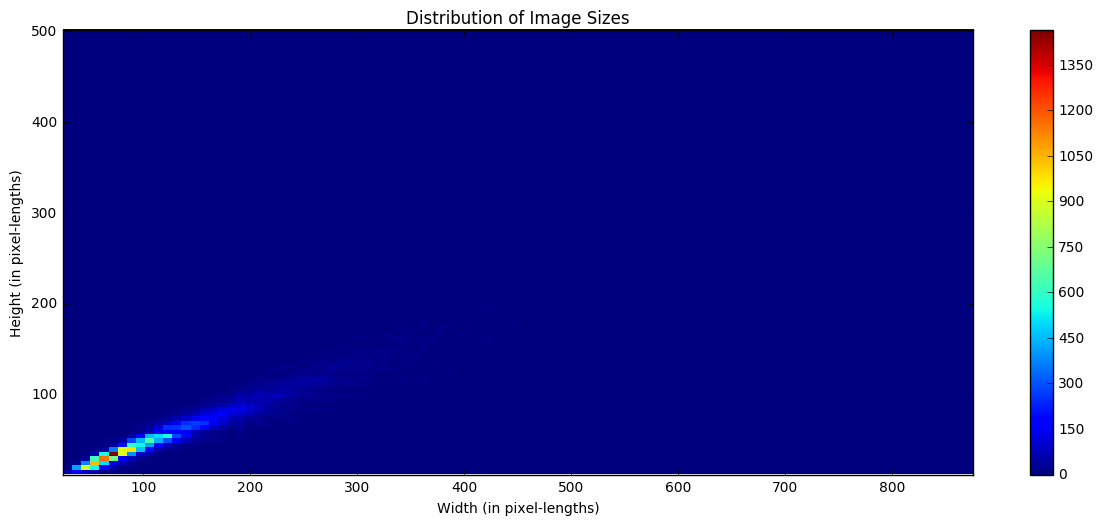

In [11]:
plt.figure(1, figsize=(12,5))
plt.hist2d(img_width, img_height, bins=100)
plt.tight_layout()
plt.colorbar()
plt.title("Distribution of Image Sizes")
plt.xlabel("Width (in pixel-lengths)")
plt.ylabel("Height (in pixel-lengths)")
plt.show()

Notice that the above plot suggests that the vast majority of the images are less than 50-or-so pixels tall, and many of them are less than 100 pixels wide.

That is, we can probably downsize these images to 64 x 64 and (hopefully) not lose a lot of information.

In [12]:
img_pixels = []
for i in range(len(img_width)):
    img_pixels.append(img_width[i] * img_height[i])

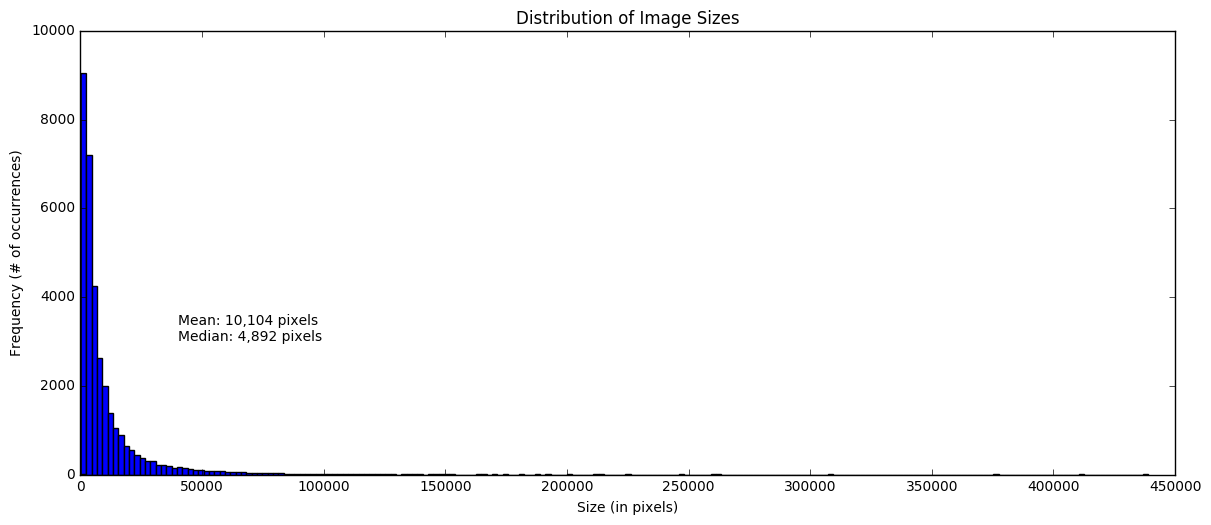

In [13]:
plt.figure(1, figsize=(12,5))
plt.hist(img_pixels, bins=200)
plt.tight_layout()
txt = "Mean: {:,.0f} pixels".format(np.mean(img_pixels))
txt += "\nMedian: {:,.0f} pixels".format(np.median(img_pixels))
plt.text(40000, 3000, txt)
plt.title("Distribution of Image Sizes")
plt.xlabel("Size (in pixels)")
plt.ylabel("Frequency (# of occurrences)")
plt.show()

Let's arbitrarily go with 128x128, the size used by Goodfellow et al.  
But hold on, we can't just rescale our input images, or we'd get too-squished input like this:

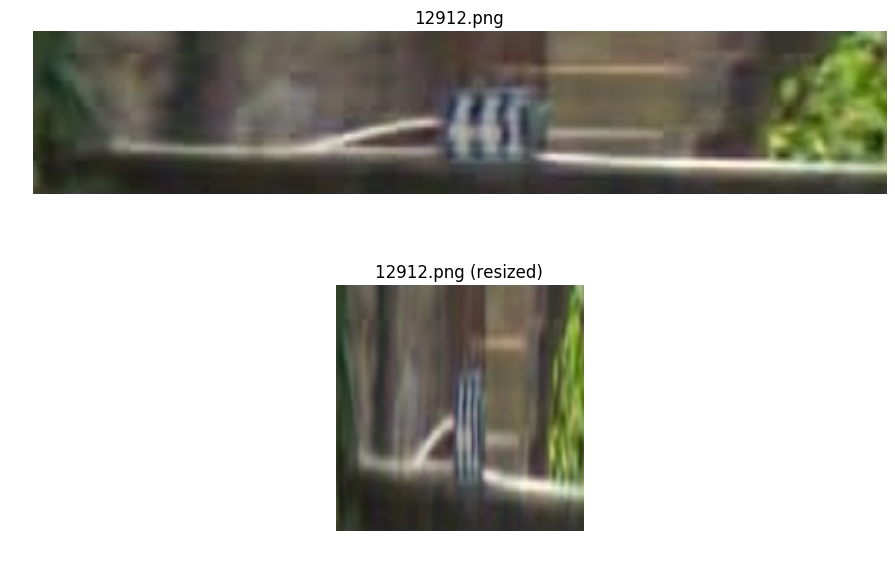

In [14]:
fig = plt.figure(figsize=(11, 7))
i = 12912
with open(directory + filenames[i-1]) as f:
    fig.add_subplot(211)
    plt.axis("off")
    plt.title(str(i) + ".png")
    img = mpimg.imread(f)
    plt.imshow(img)
    
    fig.add_subplot(212)
    plt.axis("off")
    img = misc.imresize(img, (128,128))
    plt.title(str(i) + ".png (resized)")
    plt.imshow(img)
    plt.show()

We need to be more clever about how we downsize.
## Clever Image Preprocessing
[Goodfellow et al.](https://arxiv.org/pdf/1312.6082v4.pdf) describe the following steps to their image preprocessing:
1. **Find the rectangular bounding box** that will contain individual character bounding boxes.  
   Note that this means finding `y_min`, `y_max`, `x_min`, and `x_max` such that, for each image, no bounding box is clipped.  
   Note further that, for each individual character bounding box, `x_min` is simply `metadata['left'][i]`, and `y_min` is `metadata['top'][i]` (the y-axis is positive in the downward direction).  
   Then, `y_max` can be found by adding `metadata['height'][i]` to `y_min`, and `x_max` can be found by adding `metadata['width'][i]` to `x_min`.  
   Then, we simply take the lowest of the `x_min` and `y_min`, and the largest of the `x_max` and `y_max`.

2. **Expand the rectangular bounding box** by 30% in the `x` and `y` directions.  
   This seems like they are intending to increase from the rectangle's centroid, so that if we have a `width` of 20, then `x_min` decreases by 3, and `x_max` increases by 3.
   
3.  **Crop the image** to this bounding box.  
   Note that, if the expanded bounding box extends beyond the image dimensions, the box will have to be cropped to fit the image.

4.  **Resize the image** to 64 x 64.  
   This step can make use of the pipeline we defined earlier, now that we have a better idea, for each image, where the pixels containing the digit information are located.
   
5.  **Crop several 54 x 54 images** from random locations within the 64 x 64 image.
   This step increases the size of the dataset, which is good for training purposes.
   Note that this step **may** cause us to lose some digit information:  
   1. For each image, we've defined a **rectangle** which bounds all digit boxes.  Therefore the digits are probably in that rectangle.  
   2. Then, we upsized the box by 30%, which is a 15% increase on each axis, on each side.  
   3. Then we resize, which decreases resolution, but doesn't change the relative location of boundaries.  
   4. *Then*, we crop from to 54 pixels from 64 pixels.  
   Since we would have to multiply 54 by 18.52% to get back to 64, if the pixels were all cropped from one side (as might happen due to randomness), then we may sometimes crop **inside** of the original digit-containing rectangle, and maybe even cut into some digits.  
   
   This is probably not a huge deal, but it's worth noting.
   
6. **Subtract the mean** of each image

Let's implement this preprocessing pipeline:
### Find the Rectangular Bounding Box

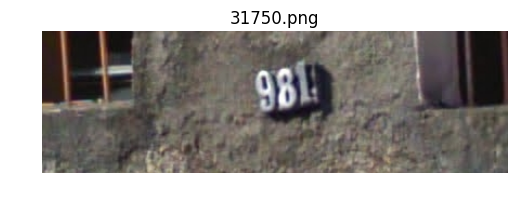

In [15]:
i = 31750
with open(directory + filenames[i - 1]) as f:
    plt.axis("off")
    plt.title(str(i) + ".png")
    img = mpimg.imread(f)
    plt.imshow(img)

In [72]:
metadata['label'][i - 1]

[9.0, 8.0, 1.0]

In [74]:
x_min = min(metadata['left'][i-1])
y_min = min(metadata['top'][i-1])
x_min, y_min

(191.0, 16.0)

In [95]:
map(add, metadata['left'][i-1], metadata['width'][i-1])

[217.0, 234.0, 259.0]

In [93]:
x_max = max(map(add, metadata['left'][i-1], metadata['width'][i-1]))
y_max = max(map(add, metadata['top'][i-1], metadata['height'][i-1]))
x_max, y_max

(259.0, 86.0)

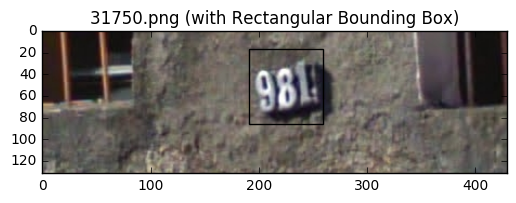

In [96]:
fig, ax = plt.subplots(1)
with open(directory + filenames[i - 1]) as f:
    bbox = patches.Rectangle((x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False)      # remove background
    ax.add_patch(bbox)
    plt.title(str(i) + ".png (with Rectangular Bounding Box)")
    img = mpimg.imread(f)
    plt.imshow(img)

fig.show()

Let's define a helper function for retrieving the bounding box:

In [7]:
def getBBox(i):
    '''
    Given i, the desired i.png, returns
    x_min, y_min, x_max, y_max,
    the four numbers which define the small rectangular bounding
    box that contains all individual character bounding boxes
    '''
    x_min = min(metadata['left'][i-1])
    y_min = min(metadata['top'][i-1])
    x_max = max(map(add, metadata['left'][i-1], metadata['width'][i-1]))
    y_max = max(map(add, metadata['top'][i-1], metadata['height'][i-1]))
    return x_min, y_min, x_max, y_max

In [8]:
print(getBBox(i))

(35.0, 8.0, 79.0, 35.0)


### Expand the Rectangular Bounding Box
Here, given a bounding box, we want to expand the box by 30% in the x and y directions, spread evenly from the centroid.

In [104]:
x_min, y_min, x_max, y_max = getBBox(i)

In [105]:
x_d = x_max - x_min
y_d = y_max - y_min
x_d, y_d

(68.0, 70.0)

In [106]:
x_min -= (0.3 * x_d) // 2
x_max += (0.3 * x_d) // 2
y_min -= (0.3 * y_d) // 2
y_max += (0.3 * y_d) // 2
x_min, y_min, x_max, y_max

(181.0, 6.0, 269.0, 96.0)

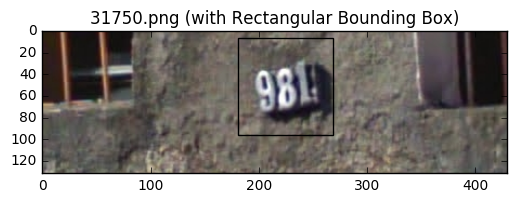

In [107]:
fig, ax = plt.subplots(1)
with open(directory + filenames[i - 1]) as f:
    bbox = patches.Rectangle((x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False)      # remove background
    ax.add_patch(bbox)
    plt.title(str(i) + ".png (with Rectangular Bounding Box)")
    img = mpimg.imread(f)
    plt.imshow(img)

fig.show()

Let's define a helper function for expanding the bounding box by 30%

In [9]:
def expandBBox(x_min, y_min, x_max, y_max):
    '''
    Given the four boundaries of the bounding box, returns
    those boundaries expanded out from the centroid by 30%, as
    x_min, y_min, x_max, y_max
    '''
    # The delta will be 30% of the width or height, (integer) halved
    x_d = ((x_max - x_min) * 0.3) // 2
    y_d = ((y_max - y_min) * 0.3) // 2
    return x_min - x_d, y_min - y_d, x_max + x_d, y_max + y_d

In [10]:
print(expandBBox(*getBBox(i)))

(29.0, 4.0, 85.0, 39.0)


### Crop the Image
Now that we have our bounding box, we need to crop the given image to fit inside that box.  
Recall that we also need to handle situations where the bounding box is outside the dimensions of the image.  
In these situations, we will simply crop the part of the bounding box that extends outside of the image.

First, let's get our crop function working on an image whose expanded bounded box is *inside* the original image.

(181.0, 6.0, 269.0, 96.0)


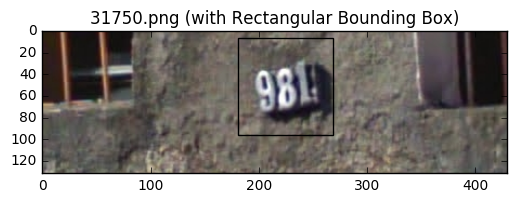

In [214]:
i = 31750
fig, ax = plt.subplots(1)
with open(directory + filenames[i - 1]) as f:
    x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
    bbox = patches.Rectangle((x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False)      # remove background
    ax.add_patch(bbox)
    plt.title(str(i) + ".png (with Rectangular Bounding Box)")
    img = mpimg.imread(f)
    plt.imshow(img)
    print(x_min, y_min, x_max, y_max)

fig.show()

(181.0, 6.0, 269.0, 96.0)


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


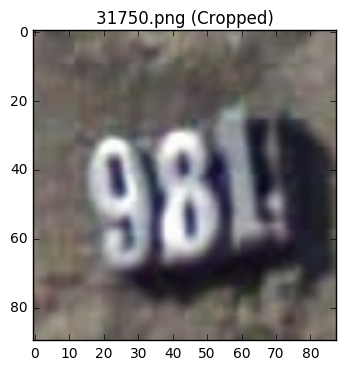

In [215]:
fig, ax = plt.subplots(1)
with open(directory + filenames[i - 1]) as f:
    x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
    bbox = patches.Rectangle((x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False)      # remove background
    ax.add_patch(bbox)
    plt.title(str(i) + ".png (Cropped)")
    img = mpimg.imread(f)
    # Slice into the Image to crop it
    plt.imshow(img[y_min:y_max, x_min:x_max])
    print(x_min, y_min, x_max, y_max)

fig.show()

Next, let's get our crop function working on an image whose expanded bounded box is *outside* the original image.

(22.0, -3.0, 40.0, 33.0)


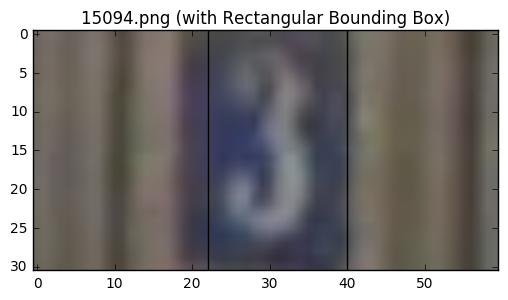

In [197]:
i = 15094
fig, ax = plt.subplots(1)
with open(directory + filenames[i - 1]) as f:
    x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
    bbox = patches.Rectangle((x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False)      # remove background
    ax.add_patch(bbox)
    plt.title(str(i) + ".png (with Rectangular Bounding Box)")
    img = mpimg.imread(f)
    plt.imshow(img)
    print(x_min, y_min, x_max, y_max)

fig.show()

(22.0, 0, 40.0, 31)


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


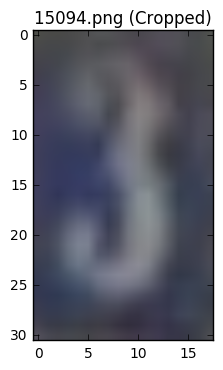

In [208]:
fig, ax = plt.subplots(1)
with open(directory + filenames[i - 1]) as f:
    x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
    
    # crop our bounding box to fit within the given image
    if x_min < 0: x_min = 0
    if y_min < 0: y_min = 0
    x_max = min(x_max, 60) # img.shape[1]
    y_max = min(y_max, 31) # img.shape[0]
    
    bbox = patches.Rectangle((x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False)      # remove background
    ax.add_patch(bbox)
    plt.title(str(i) + ".png (Cropped)")
    img = mpimg.imread(f)
    plt.imshow(img[y_min:y_max, x_min:x_max])
    print(x_min, y_min, x_max, y_max)

fig.show()

Let's define a helper function to crop the the bounding box for a given image

In [11]:
def cropBBox(img, x_min, y_min, x_max, y_max):
    '''
    Given a numpy array representing an image, and
    the four boundaries of the bounding box, returns
    the cropped bounding box, as
    x_min, y_min, x_max, y_max
    '''
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img.shape[1], x_max)
    y_max = min(img.shape[0], y_max)
    return x_min, y_min, x_max, y_max

(22.0, 0, 40.0, 31)


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


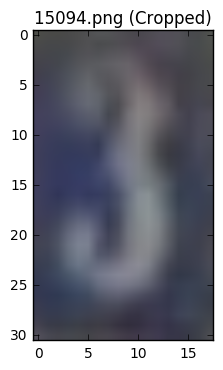

In [210]:
fig, ax = plt.subplots(1)
with open(directory + filenames[i - 1]) as f:
    img = mpimg.imread(f)
    x_min, y_min, x_max, y_max = cropBBox(img, *expandBBox(*getBBox(i)))
    
    bbox = patches.Rectangle((x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False)      # remove background
    ax.add_patch(bbox)
    plt.title(str(i) + ".png (Cropped)")
    plt.imshow(img[y_min:y_max, x_min:x_max])
    print(x_min, y_min, x_max, y_max)

fig.show()

### Resize the Image
We've already hinted at how to resize images above, but let's formalize that process by defining a helper function

In [12]:
def getResized(f):
    '''
    Given an open file f, representing the desired image file,
    returns a 64 x 64 numpy array, which is the portion of the
    image enclosed by the bounding box around all digits,
    resized to 64 pixels by 64 pixels.
    '''
    # Read the file as a numpy array
    img = mpimg.imread(f)
    
    # Get the index i from our filename
    i = int(f.name[11:].split('.')[0])

    # Get our final expanded, cropped digit-bounding box
    x_min, y_min, x_max, y_max = cropBBox(img, *expandBBox(*getBBox(i)))
    
    # Return the cropped, resized numpy array
    return misc.imresize(img[y_min:y_max, x_min:x_max], (64,64))


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


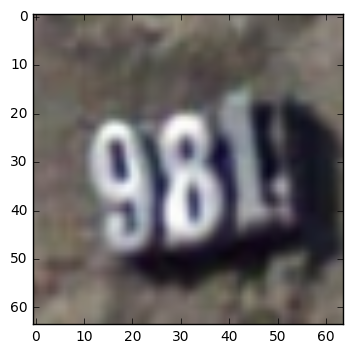

In [226]:
i = 31750
f = open(directory + str(i) + '.png')
plt.imshow(getResized(f))
f.close()

### Crop Several Smaller Images
Exactly how many smaller images we'll want is unclear (3? 5? 10?), so let's define a function that randomly returns *a single* 54 x 54 cropped image from a given 64 x 64 image.  
That way, later we can tweak how many times we call that function.

In [227]:
i = 31750
f = open(directory + str(i) + '.png')
img = getResized(f)
f.close()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
def getRandomSmaller(img):
    '''
    Given img, a 64 x 64 numpy array representing an image,
    returns a randomly-sliced 54 x 54 numpy array,
    representing a crop of the original image
    '''
    x_min = rand.randint(0,10)
    x_max = 64 - (10 - x_min)
    y_min = rand.randint(0,10)
    y_max = 64 - (10 - y_min)
    return img[y_min:y_max, x_min:x_max]

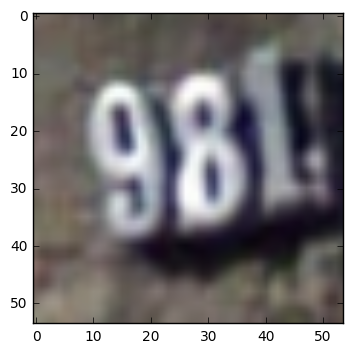

In [276]:
plt.imshow(getRandomSmaller(img))

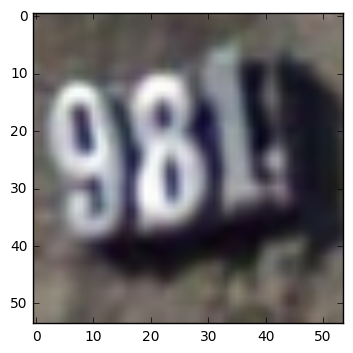

In [242]:
plt.imshow(getRandomSmaller(img))

### Subtract the mean of each image
Recall that the images are stored as numpy arrays.  
Thus, we can compute the mean of the numpy array, then subtract the mean from each index of the array.  
Note that, after having done this, we will have negative values in the numpy array.  
Thus, while the numpy array will still represent an image, it can't be displayed as an image without first handling the negatives in some way.

In [282]:
img

array([[[121, 109, 104],
        [114, 103, 101],
        [ 99,  88,  86],
        ..., 
        [130, 120, 117],
        [131, 120, 117],
        [137, 126, 123]],

       [[119, 106, 103],
        [111, 100,  99],
        [ 99,  88,  89],
        ..., 
        [136, 127, 121],
        [136, 126, 119],
        [139, 129, 122]],

       [[117, 104, 103],
        [109,  97,  97],
        [102,  91,  92],
        ..., 
        [135, 127, 117],
        [134, 124, 115],
        [137, 128, 117]],

       ..., 
       [[126, 117, 108],
        [130, 122, 112],
        [139, 133, 120],
        ..., 
        [124, 115, 105],
        [124, 115, 106],
        [130, 122, 112]],

       [[135, 126, 116],
        [137, 132, 120],
        [142, 139, 123],
        ..., 
        [115, 107,  97],
        [116, 107,  98],
        [120, 114, 103]],

       [[139, 132, 120],
        [141, 136, 123],
        [142, 139, 123],
        ..., 
        [112, 104,  93],
        [114, 108,  97],
        [118, 113,

In [283]:
np.mean(img)

98.638916015625

In [14]:
def subtractMean(img):
    '''
    Given img, a numpy array representing an image,
    subtracts the mean from the numpy array and returns
    the mean-subtracted result
    '''
    return img - np.mean(img)

In [281]:
subtractMean(img)

array([[[ 22.36108398,  10.36108398,   5.36108398],
        [ 15.36108398,   4.36108398,   2.36108398],
        [  0.36108398, -10.63891602, -12.63891602],
        ..., 
        [ 31.36108398,  21.36108398,  18.36108398],
        [ 32.36108398,  21.36108398,  18.36108398],
        [ 38.36108398,  27.36108398,  24.36108398]],

       [[ 20.36108398,   7.36108398,   4.36108398],
        [ 12.36108398,   1.36108398,   0.36108398],
        [  0.36108398, -10.63891602,  -9.63891602],
        ..., 
        [ 37.36108398,  28.36108398,  22.36108398],
        [ 37.36108398,  27.36108398,  20.36108398],
        [ 40.36108398,  30.36108398,  23.36108398]],

       [[ 18.36108398,   5.36108398,   4.36108398],
        [ 10.36108398,  -1.63891602,  -1.63891602],
        [  3.36108398,  -7.63891602,  -6.63891602],
        ..., 
        [ 36.36108398,  28.36108398,  18.36108398],
        [ 35.36108398,  25.36108398,  16.36108398],
        [ 38.36108398,  29.36108398,  18.36108398]],

       ..., 
   

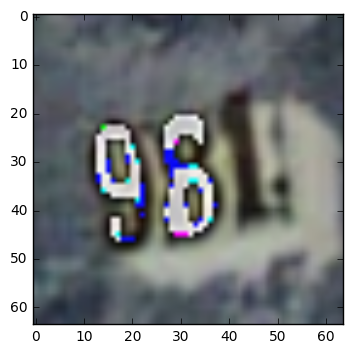

In [284]:
# Note that Matplotlib is unable to display the mean-subtracted
# numpy array without distortion
plt.imshow(subtractMean(img))

## The Training Data
### Creating and Saving  
Now that we've defined a pipeline for generating training data, let's create some.

In [15]:
num_random_subsamples = 5

In [16]:
im_array = []
for i in filenames:
    with open(directory + i, 'r') as f:
        img = getResized(f)
        for j in range(num_random_subsamples):
            im_array.append(subtractMean(getRandomSmaller(img)))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
np.save('data/train/54x54.npy', im_array)

In [17]:
np.save('data/train/54x54tenth.npy', im_array[:len(im_array)//10])

Now, we need to generate labels that match the training data that we just created.

This should consist of [Length, d1(, d2, d3, d4, d5)]

In [18]:
# where r stands for "randomCroppedLabels"
r0 = []
r1 = []
r2 = []
r3 = []
r4 = []
r5 = []
for i in range(0, l):
    a = metadata['label'][i]
    label = [len(a)]
    for n in a:
        label.append(n)
    while len(label) < 6:
        label.append(10)
    for j in range(num_random_subsamples):
        r0.append(label[0])
        r1.append(label[1])
        r2.append(label[2])
        r3.append(label[3])
        r4.append(label[4])
        r5.append(label[5])

In [ ]:
np.save('data/train/labels0.npy', r0)
np.save('data/train/labels1.npy', r1)
np.save('data/train/labels2.npy', r2)
np.save('data/train/labels3.npy', r3)
np.save('data/train/labels4.npy', r4)
np.save('data/train/labels5.npy', r5)

In [19]:
np.save('data/train/labels0tenth.npy', r0[:len(r0)//10])
np.save('data/train/labels1tenth.npy', r1[:len(r1)//10])
np.save('data/train/labels2tenth.npy', r2[:len(r2)//10])
np.save('data/train/labels3tenth.npy', r3[:len(r3)//10])
np.save('data/train/labels4tenth.npy', r4[:len(r4)//10])
np.save('data/train/labels5tenth.npy', r5[:len(r5)//10])

### Loading  
Finally, we'll want to define some helper functions for creating a train-test split of the data we just created.

#### Loading the Full Dataset

In [17]:
test_size = 0.33
cut = int((l * num_random_subsamples) * test_size)

In [ ]:
X = np.load('data/train/54x54.npy')

In [35]:
y0 = np.load('data/train/labels0.npy')
y1 = np.load('data/train/labels1.npy')
y2 = np.load('data/train/labels2.npy')
y3 = np.load('data/train/labels3.npy')
y4 = np.load('data/train/labels4.npy')
y5 = np.load('data/train/labels5.npy')

In [ ]:
X_train = X[cut:]
X_test = X[:cut]

In [36]:
y0_train = y0[cut:]
y0_test = y0[:cut]
y1_train = y1[cut:]
y1_test = y1[:cut]
y2_train = y2[cut:]
y2_test = y2[:cut]
y3_train = y3[cut:]
y3_test = y3[:cut]
y4_train = y4[cut:]
y4_test = y4[:cut]
y5_train = y5[cut:]
y5_test = y5[:cut]

In [37]:
y0_train[0], y1_train[0], y2_train[0], y3_train[0], y4_train[0], y5_train[0]

(3, 6.0, 8.0, 2.0, 10.0, 10.0)

#### Loading a Tenth of the Dataset

In [16]:
test_size = 0.33
cut = int(((l * num_random_subsamples) // 10) * test_size)

In [17]:
X = np.load('data/train/54x54tenth.npy')

In [18]:
y0 = np.load('data/train/labels0tenth.npy')
y1 = np.load('data/train/labels1tenth.npy')
y2 = np.load('data/train/labels2tenth.npy')
y3 = np.load('data/train/labels3tenth.npy')
y4 = np.load('data/train/labels4tenth.npy')
y5 = np.load('data/train/labels5tenth.npy')

In [19]:
X_train = X[cut:]
X_test = X[:cut]

In [20]:
y0_train = y0[cut:]
y0_test = y0[:cut]
y1_train = y1[cut:]
y1_test = y1[:cut]
y2_train = y2[cut:]
y2_test = y2[:cut]
y3_train = y3[cut:]
y3_test = y3[:cut]
y4_train = y4[cut:]
y4_test = y4[:cut]
y5_train = y5[cut:]
y5_test = y5[:cut]

In [21]:
y0_train[0], y1_train[0], y2_train[0], y3_train[0], y4_train[0], y5_train[0]

(3, 2.0, 4.0, 2.0, 10.0, 10)

## The Neural Net
We will be building a neural net to output the digits from input images.  The architecture will try to follow, as closely as possible, that architecture described by Goodfellow et al., below:
>Our best architecture consists of eight convolutional hidden layers, one locally connected hidden layer, and two densely connected hidden layers. All connections are feedforward and go from one layer to the next (no skip connections).  
>
The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit) while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011).  
> 
The number of units at each spatial location in each layer is [48, 64, 128, 160] for the first four layers and 192 for all other locally connected layers. The fully connected layers contain 3,072 units each.  
>
Each convolutional layer includes max pooling and subtractive normalization. The max pooling window size is 2 × 2. The stride alternates between 2 and 1 at each layer, so that half of the layers don’t reduce the spatial size of the representation.  
>
All convolutions use zero padding on the input to preserve representation size. The subtractive normalization operates on 3x3 windows and preserves representation size.  
>
All convolution kernels were of size 5 × 5. We trained with dropout applied to all hidden layers but not the input.

Below is a sketch of the model architecture that best comports with this description:
```
(0) input (54 x 54 x 3 image)
(1) same-pad 5 × 5 conv  [48] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> 3-filter maxout
(2) same-pad 5 × 5 conv  [64] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(3) same-pad 5 × 5 conv [128] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(4) same-pad 5 × 5 conv [160] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(5) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(6) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(7) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(8) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(9) flatten
(10) fully-connected [3072] -> dropout
(11) fully-connected [3072] -> dropout
(12) output
```
Note that the output itself is relatively complex (see image below), and will be dealt with in more detail after the hidden layers.
![Goodfellow et al. Neural Net Architecture](images/architecture.png)  
Note that the 128 x 128 x 3 referred to above is for the image processing pipeline for the *private* SVHN dataset, to which only Google has access.  
For the *public* SVHN dataset, that portion of the above graphic should read 54 x 54 x 3, in accordance with the preprocessing pipeline which Goodfellow et al. define in their section 5.1, which this notebook attempts to recreate.  

This model architecture will be implemented in TensorFlow, using Keras as a front-end to aid in layer construction and management.

In [22]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Dropout, Flatten, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dense
from keras.models import Model

Using TensorFlow backend.


In [23]:
img_channels = 3
img_rows = 54
img_cols = 54

In [24]:
# Layer 0: Input
x = Input((img_rows, img_cols, img_channels))

# Layer 1: 48-unit maxout convolution
y = Convolution2D(nb_filter = 48, nb_row = 5, nb_col = 5, border_mode="same", name="1conv")(x)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="1maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="1drop")(y)
# y = MaxoutDense(output_dim = 48, nb_feature=3)(y)
y = Activation('relu', name="1activ")(y)

# Layer 2: 64-unit relu convolution
y = Convolution2D(nb_filter = 64, nb_row = 5, nb_col = 5, border_mode="same", name="2conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="2maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="2drop")(y)
y = Activation('relu', name="2activ")(y)

# Layer 3: 128-unit relu convolution
y = Convolution2D(nb_filter = 128, nb_row = 5, nb_col = 5, border_mode="same", name="3conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="3maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="3drop")(y)
y = Activation('relu', name="3activ")(y)

# Layer 4: 160-unit relu convolution
y = Convolution2D(nb_filter = 160, nb_row = 5, nb_col = 5, border_mode="same", name="4conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="4maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="4drop")(y)
y = Activation('relu', name="4activ")(y)

# Layer 5: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="5conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="5maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="5drop")(y)
y = Activation('relu', name="5activ")(y)

# Layer 6: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="6conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="6maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="6drop")(y)
y = Activation('relu', name="6activ")(y)

# Layer 7: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="7conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="7maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="7drop")(y)
y = Activation('relu', name="7activ")(y)

# Layer 8: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="8conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="8maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="8drop")(y)
y = Activation('relu', name="8activ")(y)

# Layer 9: Flatten
y = Flatten()(y)

# Layer 10: Fully-Connected Layer
y = Dense(3072, activation=None, name="fc1")(y)

# Layer 11: Fully-Connected Layer
y = Dense(3072, activation=None, name="fc2")(y)

length = Dense(7, activation="softmax", name="length")(y)
digit1 = Dense(11, activation="softmax", name="digit1")(y)
digit2 = Dense(11, activation="softmax", name="digit2")(y)
digit3 = Dense(11, activation="softmax", name="digit3")(y)
digit4 = Dense(11, activation="softmax", name="digit4")(y)
digit5 = Dense(11, activation="softmax", name="digit5")(y)

model = Model(input=x, output=[length, digit1, digit2, digit3, digit4, digit5])

Now that we've defined our model, let's train it:

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(X_train,
          [y0_train, y1_train, y2_train, y3_train, y4_train, y5_train],
          validation_data=(X_test,
                           [y0_test, y1_test, y2_test, y3_test, y4_test, y5_test]),
          nb_epoch=10,
          batch_size=200,
          verbose=1)
model.evaluate(X_test,
               [y0_test, y1_test, y2_test, y3_test, y4_test, y5_test],
               verbose=0)